In [34]:
import numpy as np
import validation as validation
import algebra as algebra

In [35]:
#########################################################################
#  Operators
#  Each operator must be a class with forward and transpose methods
###########################################################################

class zero_op:
    """
        Returns 0
    """
    def forward(self,x):
        return 0.0
    def transpose(self,x):
        return 0.0

class matrix_op:
    """
        matrix_op(A) converts the matrix A to a matrix 
        operator and its transpose
    """
    def __init__(self,A):
        self.A=A
        
    def forward(self,x):
        return np.matmul(self.A,x)
    
    def transpose(self,x):
        return np.matmul(np.transpose(self.A),x)
    
    
class scalar_prod_op:
    """
       scalar_prod(a) is the scalar product with a
    """
    def __init__(self,a):
        self.a=a
        
    def forward(self,x):
        return self.a*x
    
    def transpose(self,x):
        return self.forward(x)
    
class hadamard_op:
    """
       Hadamard product. Multiply every entry of 
       x with the corresponding entry of A
    """
    def __init__(self,A):
        self.A=A
    def forward(self,x):
        return self.A*x
    def transpose(self,x):
        return self.forward(x)
    
class real_fftn_op:
    """
        FFT of real valued vectors and matrices
    """
    def forward(self,x):
        return np.fft.fftshift(np.fft.fftn(np.real(x)))
    def transpose(self,x):
        return np.real(np.fft.ifftn(np.fft.ifftshift(x)))


class real_imag_fftn_op:
    """
        FFT of a real+ imag vector or matrix
    """
    def forward(self,x):
        return algebra.complex2array(np.fft.fftshift(np.fft.fftn(algebra.array2complex(x))))
    def transpose(self,x):
        return algebra.complex2array(np.fft.ifftn(np.fft.ifftshift(algebra.array2complex(x))))


class fftn_op:
    """
        FFT of complex valued vectors and matrices
    """
    def forward(self,x):
        return np.fft.fftshift(np.fft.fftn(x))
    def transpose(self,x):
        return np.fft.ifftn(np.fft.ifftshift(x))
    
    
class composite_op:
    """
       Creates a composite operator 
       Uses mathematical notation
       That is, composite_op(A,B,C) is the operator ABC, i.e. C operates first
       followed by B followed by A
       composite_op accepts any number of operators as arguments
    """
    def __init__(self,*ops):
        self.ops=ops
        
    def forward(self,x):
        for op in reversed(self.ops):
            x=op.forward(x)
        return x
    
    def transpose(self,x):
        for op in self.ops:
            x=op.transpose(x)
        return x

    
class add_op:
    """
        Creates a sum operator
        e.g. add_op(A,B,C) gives the operator A+B+C
    """
    def __init__(self,*ops):
        self.ops=ops

    def forward(self,x):
        y=0
        for op in self.ops:
            y += op.forward(x)
        return y
    
    def transpose(self,x):
        y=0
        for op in self.ops:
            y += op.transpose(x)
        return y   

In [36]:
##########################################################
#  Utility functions for conjugate gradient
##########################################################

def inner_prod(x,y):
    """
        real and complex inner product
        Works for vectors and matrices
    """
    return np.real(np.sum(np.conj(x)*y))

def norm_sq(x):
    """
        Euclidean norm sq for vectors
        Frobenius norm sq for matrices
        Works for real and complex
    """
    return inner_prod(x,x)

def norm(x):
    """
        Euclidean norm for vectors
        Frobenius norm for matrices
        Works for real and complex
    """
    return np.sqrt(norm_sq(x))
    
            
def lhs_op(A,B):
    """
        Creates the operator on the LHS of the CG linear equation
        i.e. creates (A^TA+B^TB)
    """
    def lhs(x):
        return A.transpose(A.forward(x))+B.transpose(B.forward(x))
    return lhs
    
##################################################################
#    Conjugate gradient minimization with L2 regularization
##################################################################
    
def c_grad(y,A,x,B=zero_op(),max_iter=100,f_tol=1e-5):
    """
     Conjugate gradient algorithm for minimizing ||y-Ax||^2 + ||Bx||^2
     The second term is a regulizer, and is optional
     The termination criteria are
         either k=num_steps >= max_iter 
         or ||y-Ax||<= f_tol*||y|| (Scipy criterion)
         
    The minimizer is found by solving the linear equation
            (A^TA + B^TB)x=A^Ty
    
    Inputs: y,A,B as defined by the objective function above. A and B
                 have to be operators with forward and transpose defined
            max_iter: maximum number of iterations
            f_tol: as defined above
    
    Output: tuple (x,flag)
        where x is the solution
             flag=1 if max_iter are reached, else 0
    """
    # Mathematical comments below correspond to Wikipedia CG formulae
    # written in Latex
    # See https://en.wikipedia.org/wiki/Conjugate_gradient_method
    
    A_star=lhs_op(A,B) #A_star is the operator A^*=(A^TA + B^TB)
    b=A.transpose(y)  #A^Ty
    r_k=b-A_star(x)
    p_k=r_k
    x_k=x
    #initialize iteration
    k=0
    t=f_tol*norm(b)
    res_norm_sq=norm_sq(r_k)
    while ((k<max_iter) & (np.sqrt(res_norm_sq)>=t)):
        AtAp=A_star(p_k) #Precalculate to save flops
        alpha_k= res_norm_sq/inner_prod(p_k,AtAp) # alpha_k = r^T_kr_k/p^T_k A^*p_k
        x_k1=x_k+alpha_k*p_k                      # x_{k+1}=x_k+\alpha_k p_k
        r_k1=r_k-alpha_k*AtAp                     # r_{k+1}= r_{k}-\alpha_k A^*p_k
        beta_k=norm_sq(r_k1)/res_norm_sq          # \beta_k = r^T_{k+1}r_{k+1}/r^T_kr_k
        p_k1=r_k1+beta_k*p_k                      # p_{k+1}= r_{k+1}+\beta_k p_k
        #update
        k=k+1
        x_k=x_k1
        p_k=p_k1
        r_k=r_k1
        res_norm_sq=norm_sq(r_k)
        print(f"CG: step={k} res_norm={np.sqrt(res_norm_sq)} ")
    return x_k,k>=max_iter
        

### Test 1: Simple test without noise
#### The operator A is (MO+R). Task is to recover a vector. No regularization on CG

In [37]:
M=matrix_op(np.array(((1, 2, 3),(0, 1, 0),(2, 3,1))))
O=scalar_prod_op(2.0)
R=scalar_prod_op(0.1)
A=add_op(composite_op(M,O),R) 

x=np.array((1,0.5,1)).reshape(-1,1) #Input x
y=A.forward(x) #Create noiseless output by applying A
print(f"x={x}\n y={y}")

x0=np.zeros_like(x) #Initial value for CG
x_cg,flag=c_grad(y,A,x0)
print(f"x={x_cg} \n flag={flag}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

x=[[1. ]
 [0.5]
 [1. ]]
 y=[[10.1 ]
 [ 1.05]
 [ 9.1 ]]
CG: step=1 res_norm=3.234651420766811 
CG: step=2 res_norm=0.7480204131885724 
CG: step=3 res_norm=6.8985257123446856e-12 
x=[[1. ]
 [0.5]
 [1. ]] 
 flag=False
Original and CG are equal in absolute value


### Test 2: x is matrix, y contains noise, CG uses regularizer

In [38]:
M=matrix_op(np.array(((1, 2, 3),(0, 1, 0),(2, -3,1))))
O=scalar_prod_op(2.0)
R=scalar_prod_op(0.1)

A=add_op(composite_op(M,O),R)

x=np.transpose(np.array(((1,0.5,1),(0,1,0))))
y=A.forward(x)
y=y+0.1*np.random.normal(size=y.shape)
print(f"x={x}\n y={y}")

x0=np.zeros_like(x)
x_cg,flag=c_grad(y,A,x0,B=R,f_tol=1e-8)
print(f"x={x_cg} \n flag={flag}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

x=[[1.  0. ]
 [0.5 1. ]
 [1.  0. ]]
 y=[[10.10805704  4.07876417]
 [ 1.07846026  2.19514709]
 [ 3.26788615 -5.89732614]]
CG: step=1 res_norm=8.266345899225124 
CG: step=2 res_norm=0.3506766525666233 
CG: step=3 res_norm=2.339318167611582e-13 
x=[[ 1.07282549  0.11837938]
 [ 0.51009002  1.04215   ]
 [ 0.96898915 -0.05636509]] 
 flag=False
Original and CG are not equal in absolute value


### CG with real fft

In [39]:
x=np.random.normal(size=(4,4))
print(x)
A=real_fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
#print(f"x={x}\n y={y}")
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R)

print(x_cg)
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

[[ 1.05957924 -0.86807474 -0.6850073  -3.15064421]
 [-0.13167066 -0.04725204 -0.28993875 -0.61678077]
 [ 0.64123439 -0.40767825  0.20770128 -0.50864083]
 [ 0.88170909 -1.56520478  0.6354185  -0.67934567]]
x=[[ 1.05957924 -0.86807474 -0.6850073  -3.15064421]
 [-0.13167066 -0.04725204 -0.28993875 -0.61678077]
 [ 0.64123439 -0.40767825  0.20770128 -0.50864083]
 [ 0.88170909 -1.56520478  0.6354185  -0.67934567]]
CG: step=1 res_norm=6.131431598003248e-16 
[[ 1.05582606 -0.86151655 -0.68343842 -3.12148632]
 [-0.15075778  0.00604931 -0.2997468  -0.62865941]
 [ 0.62049973 -0.45414239  0.2485193  -0.55410534]
 [ 0.8525885  -1.56769308  0.6164485  -0.61978596]]
Original and CG are not equal in absolute value


### CG with complex fft


In [40]:
x=np.random.normal(size=(4,4))
A=fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R)

print(f"abs(x_cg)={abs(x_cg)}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.5)
print(f"angle(x_cg)={np.angle(x_cg)}")

x=[[-0.87186145  1.19516122 -0.77463246 -0.15659466]
 [ 0.32764637  0.07758987  0.43708618 -0.97888652]
 [-0.58979979  0.8335053  -0.27711091  1.41889704]
 [ 0.84113011 -2.25870093 -1.23798199  1.55384551]]
CG: step=1 res_norm=7.109738799716153e-16 
abs(x_cg)=[[0.88538527 1.22069164 0.78338222 0.1297717 ]
 [0.33205515 0.07516742 0.44961751 0.92151846]
 [0.54015632 0.86766258 0.32726714 1.44646422]
 [0.84009925 2.1886534  1.21426225 1.53680571]]
Original and CG are equal in absolute value
angle(x_cg)=[[ 3.14159265e+00 -4.27978296e-02  3.14159265e+00  2.72739785e+00]
 [ 5.95103021e-02  5.18019091e-03  1.32520156e-01  3.13610411e+00]
 [ 3.14159265e+00 -6.76118311e-02  3.14159265e+00  4.05372126e-02]
 [-2.35101511e-02 -3.13928175e+00 -3.09264699e+00 -2.53369601e-04]]


x=[[ 0.83819532  0.164821    1.1422167   1.48245401  0.          0.
   0.          0.        ]
 [-0.58725919 -0.02266007  0.06908704  0.63853796  0.          0.
   0.          0.        ]
 [-1.01747379 -0.15753993  1.97228789 -0.48759438  0.          0.
   0.          0.        ]
 [ 0.00875093  1.78954434 -0.90254886  0.76777897  0.          0.
   0.          0.        ]]
CG: step=1 res_norm=9.050651668536729e-16 
CG: step=2 res_norm=2.0673689589004437e-31 
CG: step=3 res_norm=5.333662382641413e-47 
CG: step=4 res_norm=1.726713490971014e-62 
abs(x)=[[0.83819532 0.164821   1.1422167  1.48245401]
 [0.58725919 0.02266007 0.06908704 0.63853796]
 [1.01747379 0.15753993 1.97228789 0.48759438]
 [0.00875093 1.78954434 0.90254886 0.76777897]]
abs(x_cg)=[[0.69331961 0.22119322 1.0972355  1.45761692]
 [0.58167903 0.03096684 0.14269498 0.6345649 ]
 [0.94475594 0.14165042 1.94866516 0.48434786]
 [0.04360826 1.80821321 0.88262505 0.73832748]]
Original and CG are not equal in absolute value


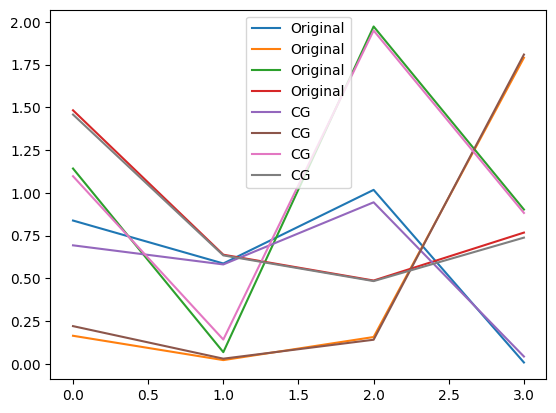

angle(x_cg)=[[ 5.42000571e-02 -1.58858132e-01  6.48916057e-02 -1.41322739e-03]
 [ 3.13689412e+00 -2.74734352e+00 -2.52167556e-01 -1.90546010e-01]
 [-3.08179268e+00 -3.09007727e+00 -1.35930469e-02 -2.87777983e+00]
 [ 7.67190851e-02  7.25733542e-03 -3.06959682e+00 -1.95689069e-02]]


In [41]:
x_size = (4,4)
x=np.random.normal(size=x_size)
x = algebra.complex2array(x)
A=real_imag_fftn_op()
# B = fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R, f_tol=1e-50)

x_comp = algebra.array2complex(x)
x_cg_comp = algebra.array2complex(x_cg)

print(f"abs(x)={abs(x_comp)}")
print(f"abs(x_cg)={abs(x_cg_comp)}")
validation.validate_equal(x_comp, x_cg_comp, "Original", "CG", rtol=0.5, make_plot=True)
print(f"angle(x_cg)={np.angle(x_cg_comp)}")

x=[[-1.21635473  0.78171033  0.80429803 -1.75429026  0.77727778  1.11612017
  -0.08194535  0.61816209]
 [-0.45657119 -0.59882514  0.3288433  -0.39635968  0.14335797 -0.27976073
  -1.35847026  0.53994152]
 [ 0.63571584 -1.21576239  0.57701545  0.27753038  1.12250976 -0.41119076
   0.38455578 -0.62271859]
 [ 1.1833706   1.20498651  0.76950611 -0.94660908 -1.24431288 -1.00067495
   0.25387751 -1.12357544]]
CG: step=1 res_norm=5.721958498152797e-16 
CG: step=2 res_norm=1.3602134910862896e-31 
CG: step=3 res_norm=6.732167060963204e-47 
CG: step=4 res_norm=3.7218672850741096e-62 
abs(x)=[[1.4434956  1.36264275 0.80846172 1.86001577]
 [0.47854859 0.66095205 1.39770503 0.66980433]
 [1.29002434 1.28341577 0.69341905 0.68176356]
 [1.71717224 1.56631505 0.81030454 1.46918023]]
abs(x_cg)=[[1.42920357 1.34915124 0.80045715 1.84159978]
 [0.47381049 0.65440797 1.38386637 0.66317261]
 [1.27725182 1.27070868 0.68655352 0.67501342]
 [1.70017054 1.55080698 0.80228172 1.45463389]]
Original and CG are equa

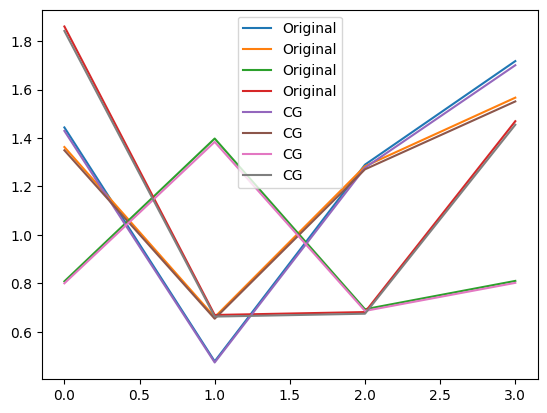

angle(x)=[[ 2.57297338  0.95981412 -0.10153396  2.8028066 ]
 [ 2.83735256 -2.70454184 -1.33329612  2.20402982]
 [ 1.05549889 -2.81545381  0.58785719 -1.15154453]
 [-0.81049595 -0.69303123  0.31867783 -2.27091843]]
angle(x_cg)=[[ 2.57297338  0.95981412 -0.10153396  2.8028066 ]
 [ 2.83735256 -2.70454184 -1.33329612  2.20402982]
 [ 1.05549889 -2.81545381  0.58785719 -1.15154453]
 [-0.81049595 -0.69303123  0.31867783 -2.27091843]]


In [42]:
x_size = (4,4)
x=np.random.normal(size=x_size)+1j*np.random.normal(size=x_size)
x = algebra.complex2array(x)

A=real_imag_fftn_op()
y=A.forward(x)
# y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R, f_tol=1e-50)

x_comp = algebra.array2complex(x)
x_cg_comp = algebra.array2complex(x_cg)

print(f"abs(x)={abs(x_comp)}")
print(f"abs(x_cg)={abs(x_cg_comp)}")
validation.validate_equal(x_comp, x_cg_comp, "Original", "CG", rtol=0.5, make_plot=True)
print(f"angle(x)={np.angle(x_comp)}")
print(f"angle(x_cg)={np.angle(x_cg_comp)}")

x=[[ 7.35954465e-01  8.66836909e-01 -6.27756434e-01 -2.20723129e+00
  -2.03703460e+00  1.08979758e+00  2.22266800e-01  1.52419618e-01]
 [ 5.17939655e-01  2.93442256e-01 -2.10210700e-03 -1.37353425e-01
   6.26134791e-02 -2.91094251e-01  6.57682970e-01  2.12722458e-01]
 [ 1.80758938e+00  1.07947151e+00  6.57366521e-01  9.32681434e-01
   1.14354247e-01  6.77359247e-01  2.17161287e+00 -1.96532747e+00]
 [-6.12858007e-01 -7.75697946e-01  1.85388517e+00  1.04483334e+00
   1.52806581e+00 -7.66911492e-01 -6.52099196e-01  9.95910083e-02]]
CG: step=1 res_norm=9.919463738466102e-16 
abs(x)=[[2.16590373 1.39250314 0.66594344 2.21248767]
 [0.52171058 0.41333306 0.65768633 0.25321297]
 [1.81120298 1.27439173 2.26892776 2.17540956]
 [1.64638393 1.09080729 1.96522864 1.04956899]]
abs(x_cg)=[[2.14445913 1.37871598 0.65934995 2.19058186]
 [0.51654513 0.40924066 0.65117458 0.25070591]
 [1.79327028 1.26177399 2.24646313 2.15387085]
 [1.6300831  1.08000722 1.94577093 1.03917722]]
Original and CG are equal i

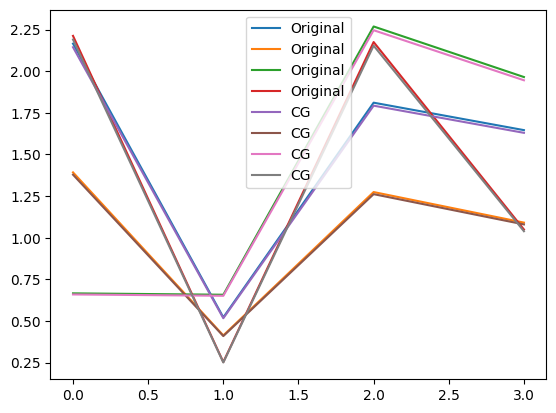

angle(x)=[[-1.22410172  0.89885987  2.80130074  3.07264744]
 [ 0.12030573 -0.78138132  1.57399255  2.14413789]
 [ 0.0631792   0.56038898  1.27685617 -1.12770056]
 [ 1.95222289 -2.36189027 -0.33823063  0.0950305 ]]
angle(x_cg)=[[-1.22410172  0.89885987  2.80130074  3.07264744]
 [ 0.12030573 -0.78138132  1.57399255  2.14413789]
 [ 0.0631792   0.56038898  1.27685617 -1.12770056]
 [ 1.95222289 -2.36189027 -0.33823063  0.0950305 ]]
x=[[-0.43908328  0.69066713  0.36247357 -1.27237712  0.53631589 -0.08397359
   0.15096326 -0.30792279]
 [-0.35295505  0.52640467 -0.22442852 -0.3237189   0.40449779 -0.01407093
  -0.65859564  0.45841471]
 [ 1.77557802  0.98441272  0.3098948   0.31005371  0.25434162  1.16527963
   1.28107651 -0.3330838 ]
 [ 1.66639934  1.00337295 -0.12019702  0.64120692  0.10096546  0.37164123
  -1.11922085 -1.71740202]]
CG: step=1 res_norm=1.0256911042741209e-15 
abs(x)=[[0.69312976 0.6957533  0.39265379 1.30910655]
 [0.53683864 0.5265927  0.69578472 0.56119335]
 [1.79370203 1.52

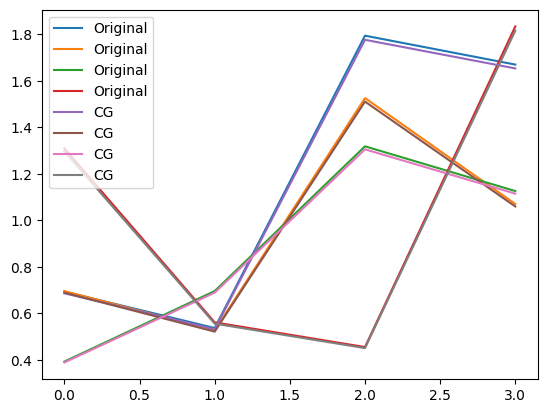

angle(x)=[[ 2.25683779 -0.12098945  0.3946327  -2.90415187]
 [ 2.28825177 -0.0267239  -1.89922336  2.18565151]
 [ 0.14227655  0.86933666  1.33345384 -0.82119183]
 [ 0.06051502  0.3547246  -1.67777977 -1.21346541]]
angle(x_cg)=[[ 2.25683779 -0.12098945  0.3946327  -2.90415187]
 [ 2.28825177 -0.0267239  -1.89922336  2.18565151]
 [ 0.14227655  0.86933666  1.33345384 -0.82119183]
 [ 0.06051502  0.3547246  -1.67777977 -1.21346541]]


In [43]:
x_size = (4,4)
x=np.random.normal(size=x_size)+1j*np.random.normal(size=x_size)
x = algebra.complex2array(x)
A=real_imag_fftn_op()
y=A.forward(x)
# y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R)

x_comp = algebra.array2complex(x)
x_cg_comp = algebra.array2complex(x_cg)

print(f"abs(x)={abs(x_comp)}")
print(f"abs(x_cg)={abs(x_cg_comp)}")
validation.validate_equal(x_comp, x_cg_comp, "Original", "CG", rtol=0.5, make_plot=True)
print(f"angle(x)={np.angle(x_comp)}")
print(f"angle(x_cg)={np.angle(x_cg_comp)}")